# Artwork Puzzle Solution
This is my solution to the ["Artwork" puzzle](https://open.kattis.com/problems/artwork) on [open.kattis.com](open.kattis.com).

---
### Spoiler Warning 
If you want to try solving the puzzle yourself **read no further!**

---
---



## Approach: Euler Characteristic
The key idea to this solution is to find the [Euler characteristic](https://en.wikipedia.org/wiki/Euler_characteristic), or equivalently the [rank](https://en.wikipedia.org/wiki/Rank_(graph_theory)), of the [dual graph](https://en.wikipedia.org/wiki/Dual_graph) to the painting.

The Euler characteristic for a graph with multiple connected components is
$$ \text{Vertices} - \text{Edges} + \text{Faces} - \text{Components} = 1.$$
For a planar graph, this quantity is always equal to 1, so to find the beauty of the painting (the number of connected components), we simply need to calculate.
$$ \text{beauty} = V - E + F - 1. $$
The tricky part is finding a graph that corresponds to a given painting where we can efficiently determine $V$, $E$, and $F$. But, we're helped by a few properties of the prompt:
1. We always start with the $m \times n$ square grid.
2. We are finding the beauty after each (straight line) paint stroke.
3. We are only adding paint strokes. That is, once a square is painted, it will never be unpainted.

The graph we will use is the dual to the grid of squares. It can be seen below as the output of the next cell (in red). Each vertex corresponds to a square. Each edge corresponds to a square edge, excluding the boundary. And each face corresponds to a corner, with one common face (the exterior face) for the boundary. Painting a square deletes a vertex and its adjacent edges. It also merges all of its adjacent faces into a single face. So the change in beauty, $dB$, after each paint stroke can be found by tracking the change in the number of vertices, edges, and faces:
$$ dB = -dV + dE - dF.$$

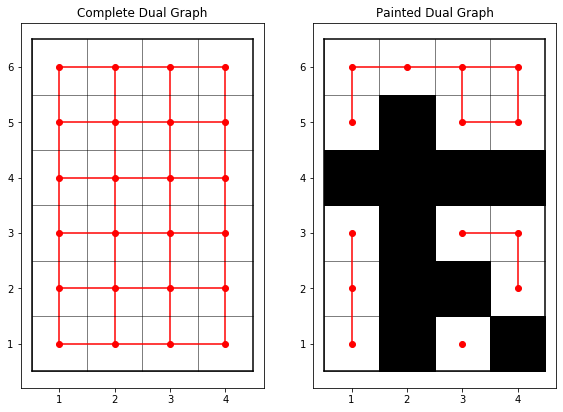

In [93]:
import matplotlib.pyplot as plt
#import numpy as np
#from matplotlib import collections
m = 4
n = 6

stroke = []
stroke.append([[1.5,2.5,2.5,1.5],[0.5,0.5,5.5,5.5]]) 
stroke.append([[0.5,4.5,4.5,0.5],[3.5,3.5,4.5,4.5]])
stroke.append([[2.5,3.5,3.5,2.5],[1.5,1.5,2.5,2.5]])
stroke.append([[3.5,4.5,4.5,3.5],[0.5,0.5,1.5,1.5]])

fig = plt.figure(figsize=(m/(m+n)*2*12, n/(m+n)*12))

ax1 = fig.add_subplot(1,2,1)
ax1.title.set_text('Complete Dual Graph')
ax1.set_aspect('equal')
for mi in range(m):
    ax1.plot([mi+0.5,mi+0.5],[0.5,n+0.5],color='k',linewidth=0.5)
    ax1.plot([mi+1,mi+1],[1,n],color='r')
    for ni in range(n):
        ax1.scatter(mi+1,ni+1,color='r')
for ni in range(n):
    ax1.plot([0.5,m+0.5],[ni+0.5,ni+0.5],color='k',linewidth=0.5)
    ax1.plot([1,m],[ni+1,ni+1],color='r')
ax1.plot([0.5,0.5],[0.5,n+0.5],color='k')
ax1.plot([0.5,m+0.5],[0.5,0.5],color='k')
ax1.plot([m+0.5,m+0.5],[0.5,n+0.5],color='k')
ax1.plot([0.5,m+0.5],[n+0.5,n+0.5],color='k')

ax2 = fig.add_subplot(1,2,2)
ax2.title.set_text('Painted Dual Graph')
ax2.set_aspect('equal')
for mi in range(m):
    ax2.plot([mi+0.5,mi+0.5],[0.5,n+0.5],color='k',linewidth=0.5)
for ni in range(n):
    ax2.plot([0.5,m+0.5],[ni+0.5,ni+0.5],color='k',linewidth=0.5)
ax2.plot([0.5,0.5],[0.5,n+0.5],color='k')
ax2.plot([0.5,m+0.5],[0.5,0.5],color='k')
ax2.plot([m+0.5,m+0.5],[0.5,n+0.5],color='k')
ax2.plot([0.5,m+0.5],[n+0.5,n+0.5],color='k')
ax2.scatter([1,3,1,4,1,3,4,1,3,4,1,2,3,4],[1,1,2,2,3,3,3,5,5,5,6,6,6,6],color='r')
ax2.plot([1,1],[1,3],color='r')
ax2.plot([4,4],[2,3],color='r')
ax2.plot([3,4],[3,3],color='r')
ax2.plot([1,1],[5,6],color='r')
ax2.plot([3,4],[5,5],color='r')
ax2.plot([3,3],[5,6],color='r')
ax2.plot([4,4],[5,6],color='r')
ax2.plot([1,4],[6,6],color='r')
for st in stroke:
    ax2.fill(st[0],st[1],color='k')

plt.show()

## Data Structure and Algorithm
Essentially, each vertex is an object, but they are simple enough that we need not define a class for them. A vertex has five boolean properties: existence, and adjacency (edge connection) to each of its four nearest neighbors. So it suffices to store these data in an $m \times n \times 5$ boolean array: `squares`. Each square `i,j` starts with `square[i][j][0]=True`. For interior squares, all four of `squares[i][j][1]` to `squares[i][j][4]` are `True`. Non-corner edge have three of the four values `True` and one `False`. The four corner squares have two `True` and two `False`. This array is currently a non-sparse numpy `ndarray`. 

Painting a stroke is treated as a sequence of painting individual squares. Painting a square deletes the vertex and all of its adjacent edges. So for square `i,j` it sets `squares[i][j] = [False,False,False,False,False]`. It also sets the corresponding value (1-4) in each adjacent square to `False`. If a square is already painted (index `0` is `False`), the loop continues past it. 

`beauty` is initialized to `1`. It is incremented/decremented whenever an edge/vertex is deleted.

Counting faces is a bit more tricky. Each square (dual vertex) assigns its index to one of its four corners (dual faces). In cartesian coordinates (origin in the lower-left), this is the upper right corner. In graphical coordinates (origin in the upper-left) it's the lower right corner. (Although this assignment is arbitrary). Boundary corners are all assigned the index `0`. A `faceref` list is used to track the "true" index of each face. This can be thought of as a (pseudo) key-value or pointer-referant table. Initially each value of `faceref` is equal to its index, except for boundary values (`y=0`, `y=n`, `x=0`, and `x%m = 0`) which are `0`. Painting a stroke merges all faces adjacent to deleted vertices into a single face. Or, in the dual view, it merges all corners along the boundary of the stroke. This is handled by setting the value of `faceref` at each merged face equal to the minimum value of the merged faces. Care must be taken to insure that the "true" value is used, which could become confused after multiple strokes are painted. So we "drill down" through `faceref` until an "identity" is found. That is, the true value is found when `faceref[i] = i`.

## Performance
So far, I've only tested this algorithm in this Jupyter notebook. I verified its accuracy on a few small paintings that I could check by hand, making sure to check particularly pathological configurations. It would be helpful to have some larger/maximal, verified data sets to check it against. 

I then tested it on some randomly generated maximal sets (`m = n = 1000`, `q = 10000`). It pretty consistently completes in about $12 \pm 1$ seconds. I have not benchmarked its scaling, but based on the method used, I would expect it to scale as $\mathcal{O}(n \log(n))$, where $n$ is the number of (unique?) squares painted. And judging a few test values by eye, that seems about right.

### Possible Improvements
As I said, I have not yet tested it as compiled code. This would likely speed up its performance immensely.

The main place it could be improved is in the format of the data structures. The `squares` array could be sparsified. Doing so optimally is a bit tricky since initially it's almost all `True`, but by the end it's largely `False`. Also, a numpy array may not be the best for fast lookup times. Another list-like structure (eg. a dictionary) may be faster. The edges and faces could also possibly be handled better in a language like C/C++ that allows for explicit pointer referencing/dereferencing.

In [107]:
# Initialize some stuff first so it doesn't count against my time.
from numpy.random import *
import numpy as np
import time

seed(10989)
m = 1000
n = 1000
q = 10000

def randomstroke(m,n):
    x1=randint(1,m+1)
    y1=randint(1,n+1)
    coinflip=randint(2)
    if coinflip:
        x2=randint(1,m+1)
        y2=y1
    else:
        x2=x1
        y2=randint(1,n+1)
    return '{0} {1} {2} {3}'.format(x1,y1,x2,y2)
#print(randomstroke(m,n))

def makestrokelist(m,n,q):
    slist = []
    for nq in range(q):
        slist.append(randomstroke(m,n))
    return slist

strokelist = makestrokelist(m,n,q)

# Actual solution starts here.
start = time.time()

beauty = 1
    
squares = np.ones((m,n,5),dtype=bool)
squares[0,:,1]=0
squares[m-1,:,2]=0
squares[:,0,3]=0
squares[:,n-1,4]=0
faceref = list(range(0,m*(n-1)))
for i in range(m,len(faceref),m):
    faceref[i]=0

def faces(x,y):
    '''
    x and y are 1-indexed as in the prompt.
    c1, c2, c3, c4 are upper-left, upper-right, lower-left, lower-right.
    '''
    c1 = 0 if (x==1 or y==1) else m*(y-2)+x-1
    c2 = 0 if (x==m or y==1) else m*(y-2)+x
    c3 = 0 if (x==1 or y==n) else m*(y-1)+x-1
    c4 = 0 if (x==m or y==n) else m*(y-1)+x
    return faceref[c1],faceref[c2],faceref[c3],faceref[c4]

def paintstroke(stroke):    
    global beauty
    mergeset=set()
    
    def addtomerge(face):
        while face != faceref[face]:
            face = faceref[face]
        mergeset.add(face)

    def paintsquare(x,y):
        global beauty
        if squares[x-1,y-1,0]:
            beauty-=1
            squares[x-1,y-1,0]=0
            f1,f2,f3,f4 = faces(x,y)
            if squares[x-1,y-1,1]:
                beauty+=1
                squares[x-1,y-1,1]=0
                addtomerge(f1)
                addtomerge(f3)
                if x>1:
                    squares[x-2,y-1,2]=0
            if squares[x-1,y-1,2]:
                beauty+=1
                squares[x-1,y-1,2]=0
                addtomerge(f2)
                addtomerge(f4)
                if x<m:
                    squares[x,y-1,1]=0
            if squares[x-1,y-1,3]:
                beauty+=1
                squares[x-1,y-1,3]=0
                addtomerge(f1)
                addtomerge(f2)
                if y>1:
                    squares[x-1,y-2,4]=0
            if squares[x-1,y-1,4]:
                beauty+=1
                squares[x-1,y-1,4]=0
                addtomerge(f3)
                addtomerge(f4)
                if y<n:
                    squares[x-1,y,3]=0
        
    x1,y1,x2,y2 = (int(n) for n in stroke.split())
    for xi in range(x1,x2+1):
        for yi in range(y1,y2+1):
            paintsquare(xi,yi)
    #print(mergeset)
    if mergeset:
        beauty-=(len(mergeset)-1)
        minf = min(mergeset)
        while minf!=faceref[minf]:
            print("faceref needed to be fixed.")
            minf = faceref[minf]
        for s in mergeset:
            faceref[s]=minf
        
for qi in range(q):
    paintstroke(strokelist[qi])
    print(beauty)
    
end = time.time()

print(end-start)

1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
3
4
5
5
5
5
5
5
5
5
5
6
6
6
6
6
6
6
8
8
8
10
10
10
10
10
12
12
12
12
12
12
12
15
17
17
17
22
22
22
22
23
23
23
23
23
23
23
23
28
34
34
38
38
38
38
38
38
38
38
38
43
43
44
44
44
45
45
45
45
46
46
46
58
58
63
63
63
65
72
80
80
80
82
83
83
83
83
83
83
84
84
84
88
88
88
88
88
88
91
92
92
93
93
95
95
95
95
95
96
96
97
98
105
105
105
105
105
105
105
105
105
106
106
109
127
127
127
127
127
127
131
131
131
131
131
139
139
139
146
147
147
147
147
147
152
152
152
153
153
153
162
164
164
166
166
170
170
170
170
170
170
170
170
170
170
170
171
171
177
177
177
181
181
184
187
193
193
193
195
197
200
200
200
202
202
202
226
226
226
226
227
231
231
235
235
243
243
243
243
243
243
243
243
243
243
253
253
255
261
270
270
297
297
297
315
319
319
319
319
319
319
319
322
322
322
326
326
327
334
340
340
340
340
340
340
343
343
343
343
346
354
354
354
362
362
362
362
362
362
372
372
372
372
381
395
395
395
395
395
395
399
399
399
399
40

12842
12842
12884
12884
12884
12884
12893
12893
12893
12893
12893
12893
12893
12893
12899
12899
12899
12899
12899
12899
13018
13018
13077
13083
13083
13091
13093
13093
13093
13122
13122
13163
13163
13163
13163
13227
13233
13251
13369
13387
13387
13391
13414
13426
13426
13487
13487
13487
13487
13487
13534
13534
13534
13543
13543
13543
13562
13595
13595
13595
13667
13667
13677
13691
13691
13691
13691
13691
13706
13706
13706
13706
13706
13801
13816
13819
13821
13829
13859
13859
13859
13859
13900
13900
13900
13900
13956
13956
13956
13956
14017
14099
14099
14100
14100
14100
14100
14100
14100
14112
14112
14112
14112
14129
14173
14173
14173
14173
14173
14173
14186
14186
14186
14189
14213
14240
14240
14240
14330
14330
14330
14330
14330
14330
14381
14416
14416
14416
14416
14417
14417
14417
14417
14417
14417
14417
14417
14417
14417
14417
14417
14437
14466
14466
14514
14498
14498
14498
14499
14499
14603
14623
14623
14623
14625
14626
14796
14796
14796
14796
14823
14823
14823
14823
14823
14823
1483

28672
28672
28708
28708
28708
28760
28760
28760
28708
28708
28708
28734
28747
28747
28747
28747
28809
28876
28876
28876
28898
28898
28913
28913
28930
28930
29025
29025
29030
29030
29002
28985
28985
28985
28985
29090
29090
29093
29093
29093
29093
29120
29120
29120
29120
29120
29253
29253
29253
29253
29262
29262
29262
29262
29262
29262
29275
29275
29275
29275
29275
29275
29313
29306
29302
29302
29358
29468
29595
29595
29595
29595
29595
29564
29564
29564
29564
29564
29630
29630
29688
29688
29699
29699
29719
29719
29736
29744
29744
29744
29756
29756
29756
29756
29756
29759
29781
29830
29830
29830
29830
29917
29917
29917
29917
29917
29927
29927
29927
29948
29948
29948
29948
29948
29964
29964
29964
29964
29964
29964
29980
30039
30033
30033
30033
30033
30079
30079
30088
30174
30174
30174
30236
30236
30236
30245
30245
30245
30269
30269
30269
30345
30345
30345
30360
30376
30376
30278
30332
30349
30368
30447
30491
30491
30491
30559
30559
30559
30559
30559
30620
30620
30620
30620
30620
30620
3062

40417
40417
40417
40417
40409
40410
40460
40460
40460
40460
40463
40463
40500
40500
40549
40587
40575
40546
40548
40548
40548
40548
40598
40598
40626
40626
40626
40626
40626
40626
40626
40626
40627
40625
40642
40642
40642
40642
40642
40668
40668
40703
40703
40693
40693
40706
40706
40670
40624
40624
40624
40624
40624
40663
40663
40663
40663
40577
40577
40577
40577
40609
40600
40535
40535
40588
40588
40588
40588
40588
40588
40590
40590
40545
40547
40547
40547
40547
40570
40570
40570
40588
40588
40588
40588
40626
40758
40758
40758
40762
40731
40731
40671
40671
40671
40584
40584
40595
40595
40595
40595
40595
40643
40643
40643
40643
40643
40643
40680
40680
40680
40680
40681
40681
40708
40708
40754
40754
40754
40754
40758
40758
40758
40758
40758
40824
40824
40865
40865
40865
40865
40865
40865
40865
40884
40884
40884
40895
40895
40895
40893
40893
40847
40847
40847
40847
40849
40849
40849
40886
40911
40916
40912
40912
40912
40912
40912
40912
40915
40915
40915
40915
40915
40915
40915
40954
4096

44713
44713
44713
44783
44783
44783
44785
44785
44785
44784
44803
44803
44955
44955
44945
44945
44959
44891
44891
44891
44891
44991
44991
44991
44991
44991
44991
45022
45022
45022
45024
45043
45043
45043
45043
45046
44986
45060
45060
45060
45060
45060
45060
45060
45034
45034
45034
45036
45036
45036
45036
45036
45036
45036
45063
45063
45066
45066
45091
45091
45133
45133
45133
45145
45145
45152
45146
45162
45162
45214
45214
45214
45239
45239
45239
45260
45260
45260
45260
45260
45260
45260
45195
45195
45197
45197
45197
45197
45197
45197
45198
45198
45198
45189
45189
45189
45194
45194
45137
45137
45183
45183
45183
45183
45183
45183
45186
45186
45186
45192
45192
45192
45192
45192
45192
45192
45192
45192
45192
45192
45192
45192
45192
45192
45177
45177
45177
45177
45177
45177
45177
45177
45177
45174
45174
45121
45121
45121
45121
45121
45121
45121
45122
45106
45106
45106
45106
45106
45237
45237
45237
45237
45237
45237
45226
45226
45226
45222
45239
45230
45217
45217
45223
45300
45300
45300
4530

47066
47066
47130
47243
47269
47267
47267
47248
47270
47231
47231
47231
47177
47177
47242
47287
47244
47244
47244
47244
47244
47244
47244
47244
47264
47264
47264
47264
47264
47264
47264
47292
47303
47303
47303
47276
47276
47276
47276
47253
47253
47253
47200
47200
47200
47200
47200
47200
47200
47200
47200
47200
47200
47200
47200
47200
47200
47200
47200
47234
47234
47238
47238
47238
47238
47238
47160
47124
47167
47167
47167
47192
47192
47178
47178
47178
47178
47178
47178
47178
47178
47178
47183
47183
47183
47183
47184
47184
47184
47231
47231
47231
47236
47236
47236
47236
47256
47256
47256
47256
47256
47256
47270
47275
47275
47275
47296
47308
47308
47332
47332
47345
47345
47360
47360
47405
47447
47423
47423
47360
47360
47360
47360
47360
47372
47372
47372
47415
47384
47392
47392
47392
47392
47392
47422
47387
47412
47430
47428
47428
47428
47428
47428
47428
47428
47343
47343
47343
47343
47341
47341
47341
47341
47382
47326
47326
47354
47354
47388
47388
47388
47388
47388
47380
47380
47380
4738

45859
45859
45859
45864
45864
45864
45864
45824
45824
45824
45824
45824
45824
45824
45824
45824
45824
45887
45887
45887
45887
45819
45819
45819
45819
45819
45819
45819
45817
45810
45839
45839
45839
45845
45845
45845
45841
45842
45842
45842
45842
45842
45842
45842
45824
45824
45824
45824
45824
45824
45824
45824
45824
45824
45824
45799
45799
45799
45799
45775
45775
45779
45779
45779
45779
45779
45779
45778
45829
45829
45832
45810
45787
45787
45787
45781
45781
45781
45781
45781
45650
45650
45650
45650
45650
45650
45650
45650
45646
45646
45646
45646
45646
45676
45676
45676
45711
45711
45711
45706
45706
45706
45706
45706
45890
45884
45884
45884
45884
45884
45884
45884
45884
45884
45884
45928
45848
45848
45875
45875
45875
45875
45875
45875
45875
45844
45844
45844
45829
45829
45829
45829
45829
45829
45829
45829
45829
45829
45829
45849
45849
45849
45849
45849
45838
45838
45834
45834
45715
45715
45715
45715
45715
45723
45723
45761
45810
45810
45809
45809
45809
45809
45809
45809
45821
45821
4582